In [1]:
# This will be the main file used to train the data

In [2]:
import os

In [3]:
# Establish directories
basedir =  os.getcwd()
traindir = os.path.join(basedir, "train")
validationdir = os.path.join(basedir, "validation")
testdir = os.path.join(basedir, "test")

In [4]:
# Tweek dropout layer

In [26]:
class_num = 8
img_size = 200

In [27]:
# Using pretrained model
from keras.applications import VGG16
# from keras.applications import ConvNeXtSmall

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(img_size, img_size, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [28]:
ts1 = 6
ts2 = 512

In [35]:
import gc
gc.collect()

13729

In [30]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 50

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, ts1, ts1, ts2))
    labels = np.zeros(shape=(sample_count, class_num))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(traindir, class_num * 750)
validation_features, validation_labels = extract_features(validationdir, class_num * 150)
test_features, test_labels = extract_features(testdir, class_num * 150)

Found 5600 images belonging to 8 classes.
2/2 [==============================] - 0s 219ms/step
Found 1200 images belonging to 8 classes.
2/2 [==============================] - 0s 219ms/step
Found 1200 images belonging to 8 classes.
2/2 [==============================] - 0s 219ms/step


2/2 [==============================] - 0s 219ms/step


In [31]:
reshape_train_features = np.reshape(train_features, (class_num * 750, ts1 * ts1 * ts2))
reshape_validation_features = np.reshape(validation_features, (class_num * 150, ts1 * ts1 * ts2))
reshape_test_features = np.reshape(test_features, (class_num * 150, ts1 * ts1 * ts2))

In [32]:
# Defining and training the densely connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=ts1 * ts1 * ts2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(class_num, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='categorical_crossentropy',
    metrics=['acc'])

In [33]:
history = model.fit(reshape_train_features, train_labels,
                    epochs=200,
                    batch_size=150,
                    validation_data=(reshape_validation_features, validation_labels))

Epoch 1/200
40/40 [==============================] - 1s 20ms/step - loss: 1.9852 - acc: 0.2467 - val_loss: 1.7115 - val_acc: 0.4775
Epoch 2/200
40/40 [==============================] - 1s 14ms/step - loss: 1.6675 - acc: 0.4188 - val_loss: 1.5378 - val_acc: 0.5467
Epoch 3/200
40/40 [==============================] - 1s 14ms/step - loss: 1.5065 - acc: 0.4997 - val_loss: 1.4220 - val_acc: 0.5625
Epoch 4/200
40/40 [==============================] - 1s 14ms/step - loss: 1.4001 - acc: 0.5413 - val_loss: 1.3309 - val_acc: 0.5942
Epoch 5/200
40/40 [==============================] - 1s 14ms/step - loss: 1.3214 - acc: 0.5715 - val_loss: 1.2693 - val_acc: 0.6200
Epoch 6/200
40/40 [==============================] - 1s 14ms/step - loss: 1.2478 - acc: 0.6032 - val_loss: 1.2096 - val_acc: 0.6358
Epoch 7/200
40/40 [==============================] - 1s 15ms/step - loss: 1.1939 - acc: 0.6220 - val_loss: 1.1636 - val_acc: 0.6442
Epoch 8/200
40/40 [==============================] - 1s 14ms/step - loss: 1.

40/40 [==============================] - 1s 14ms/step - loss: 0.3657 - acc: 0.9140 - val_loss: 0.7507 - val_acc: 0.7558
Epoch 63/200
40/40 [==============================] - 1s 14ms/step - loss: 0.3640 - acc: 0.9160 - val_loss: 0.7408 - val_acc: 0.7550
Epoch 64/200
40/40 [==============================] - 1s 13ms/step - loss: 0.3542 - acc: 0.9128 - val_loss: 0.7388 - val_acc: 0.7575
Epoch 65/200
40/40 [==============================] - 1s 14ms/step - loss: 0.3437 - acc: 0.9160 - val_loss: 0.7364 - val_acc: 0.7625
Epoch 66/200
40/40 [==============================] - 1s 14ms/step - loss: 0.3430 - acc: 0.9202 - val_loss: 0.7341 - val_acc: 0.7575
Epoch 67/200
40/40 [==============================] - 1s 15ms/step - loss: 0.3353 - acc: 0.9215 - val_loss: 0.7475 - val_acc: 0.7583
Epoch 68/200
40/40 [==============================] - 1s 14ms/step - loss: 0.3296 - acc: 0.9257 - val_loss: 0.7336 - val_acc: 0.7608
Epoch 69/200
40/40 [==============================] - 1s 14ms/step - loss: 0.3185 

40/40 [==============================] - 1s 14ms/step - loss: 0.1225 - acc: 0.9848 - val_loss: 0.7207 - val_acc: 0.7700
Epoch 124/200
40/40 [==============================] - 1s 14ms/step - loss: 0.1232 - acc: 0.9857 - val_loss: 0.7249 - val_acc: 0.7700
Epoch 125/200
40/40 [==============================] - 1s 14ms/step - loss: 0.1200 - acc: 0.9860 - val_loss: 0.7348 - val_acc: 0.7692
Epoch 126/200
40/40 [==============================] - 1s 14ms/step - loss: 0.1173 - acc: 0.9873 - val_loss: 0.7239 - val_acc: 0.7683
Epoch 127/200
40/40 [==============================] - 1s 14ms/step - loss: 0.1127 - acc: 0.9878 - val_loss: 0.7293 - val_acc: 0.7750
Epoch 128/200
40/40 [==============================] - 1s 15ms/step - loss: 0.1161 - acc: 0.9867 - val_loss: 0.7260 - val_acc: 0.7650
Epoch 129/200
40/40 [==============================] - 1s 14ms/step - loss: 0.1120 - acc: 0.9887 - val_loss: 0.7288 - val_acc: 0.7675
Epoch 130/200
40/40 [==============================] - 1s 14ms/step - loss: 

40/40 [==============================] - 1s 14ms/step - loss: 0.0419 - acc: 0.9973 - val_loss: 0.7764 - val_acc: 0.7708
Epoch 185/200
40/40 [==============================] - 1s 14ms/step - loss: 0.0397 - acc: 0.9987 - val_loss: 0.7832 - val_acc: 0.7625
Epoch 186/200
40/40 [==============================] - 1s 14ms/step - loss: 0.0405 - acc: 0.9983 - val_loss: 0.7824 - val_acc: 0.7675
Epoch 187/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0397 - acc: 0.9990 - val_loss: 0.7743 - val_acc: 0.7717
Epoch 188/200
40/40 [==============================] - 1s 14ms/step - loss: 0.0389 - acc: 0.9985 - val_loss: 0.7924 - val_acc: 0.7675
Epoch 189/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0385 - acc: 0.9982 - val_loss: 0.7828 - val_acc: 0.7708
Epoch 190/200
40/40 [==============================] - 1s 14ms/step - loss: 0.0372 - acc: 0.9993 - val_loss: 0.7873 - val_acc: 0.7642
Epoch 191/200
40/40 [==============================] - 1s 14ms/step - loss: 

In [34]:
model.evaluate(reshape_test_features, test_labels)

38/38 [==============================] - 0s 4ms/step - loss: 0.8422 - acc: 0.7817


[0.8422263264656067, 0.7816666960716248]

In [37]:
model.save('VGG16_0_78.h5')

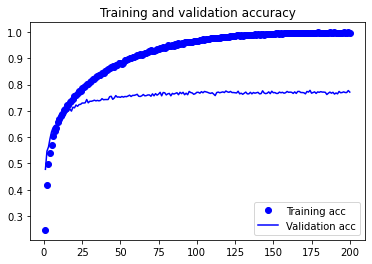

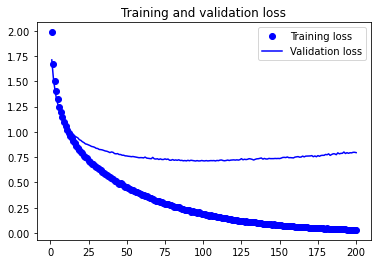

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()